In [1]:
import networkx as nx


In [2]:
ka = nx.read_edgelist('facebook_combined.txt')

In [3]:
print(nx.info(ka))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [2]:
import os

DATA_DIRECTORY = '/home/younes'
LIVEJOURNAL_FILENAME = os.path.join(DATA_DIRECTORY, 'facebook_combined.txt.gz')
LIVEJOURNAL_URL = 'http://snap.stanford.edu/data/facebook_combined.txt.gz'

# Constants for you to change



# Just have these hardcoded, though we don't really need to
NUM_EDGES = 88234
NUM_NODES = 4039


In [3]:
# Downloading the file
import urllib.request

assert os.path.exists(DATA_DIRECTORY)

# Get your data. This file is ~250M so it will take a bit
print('DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE')
if not os.path.exists(LIVEJOURNAL_FILENAME):
    urllib.request.urlretrieve(LIVEJOURNAL_URL, LIVEJOURNAL_FILENAME)

# Show a little bit of the file
print('\nFILE STATS:')
!ls -lh $LIVEJOURNAL_FILENAME
print('\nSTARTING LINES')
!zcat $LIVEJOURNAL_FILENAME | head -n 30

DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE

FILE STATS:
-rw-rw-r-- 1 younes younes 214K أبر 22 14:10 /home/younes/facebook_combined.txt.gz

STARTING LINES
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30

gzip: stdout: Broken pipe


In [4]:
# Cleaning the data

import numpy as np
import gzip

def row_generator():
    """This will generate all the edges in the graph."""
    with gzip.open(LIVEJOURNAL_FILENAME, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            else:
                (left_node, right_node) = line.split(' ')
                yield(int(left_node), int(right_node))

def to_undirected(edge_iterable, num_edges, num_nodes, shuffle=True):
    """Takes an iterable of edges and produces the list of edges for the undirected graph.
    
    > to_undirected([[0,1],[1,2],[2,10]], 3, 11)
    array([[ 0,  1],
       [ 1,  0],
       [ 1,  2],
       [ 2,  1],
       [ 2, 10],
       [10,  2]])
    """
    # need int64 to do gross bithacks
    as_array = np.zeros((num_edges, 2), dtype=np.int64)
    for (i, (n_0, n_1)) in enumerate(edge_iterable):
            as_array[i,0] = n_0
            as_array[i,1] = n_1
    # The graph is directed, but we want to make it undirected,
    # which means we will duplicate some rows.

    left_nodes = as_array[:,0]
    right_nodes = as_array[:,1]
    
    if shuffle:
        the_shuffle = np.arange(num_nodes)
        np.random.shuffle(the_shuffle)
        left_nodes = the_shuffle.take(left_nodes)
        right_nodes = the_shuffle.take(right_nodes)

    
    # numpy.unique will not unique whole rows, so this little bit-hacking
    # is a quick way to get unique rows after making a flipped copy of
    # each edge.
    max_bits = int(np.ceil(np.log2(num_nodes + 1)))
    
    encoded_edges_forward = np.left_shift(left_nodes, max_bits) | right_nodes
    
    # Flip the columns and do it again:
    encoded_edges_reverse = np.left_shift(right_nodes, max_bits) | left_nodes

    unique_encoded_edges = np.unique(np.hstack((encoded_edges_forward, encoded_edges_reverse)))
    
    left_node_decoded = np.right_shift(unique_encoded_edges, max_bits)
    
    # Mask out the high order bits
    right_node_decoded = (2 ** (max_bits) - 1) & unique_encoded_edges
    
    undirected_edges = np.vstack((left_node_decoded, right_node_decoded)).T.astype(np.int32)

    # ascontiguousarray so that it's c-contiguous for cython code below
    return np.ascontiguousarray(undirected_edges)


def get_clean_data(shuffle=True):
    if shuffle:
        name = os.path.join(DATA_DIRECTORY, 'LJ-face-shuffled.npy')
    else:
        name = os.path.join(DATA_DIRECTORY, 'LJ-face.npy')

    if os.path.exists(name):
        print('Loading from file {}'.format(name))
        return np.load(name)
    else:
        print('Parsing from zip. Will write to file {}'.format(name), flush=True)
        # Lets get the edges into one big array
        edges = to_undirected(row_generator(), NUM_EDGES, NUM_NODES, shuffle=shuffle)
        print('ORIGINAL DIST: {} MIN: {} MAX: {}'.format(np.abs(edges[:,0] - edges[:,1]).mean(), edges.min(), edges.max()))
        np.save(name, edges)
        return edges

In [5]:
print("Normalizing data (or loaded pre-computed)")
%time edges = get_clean_data(shuffle=True)
%time unshuffled_edges = get_clean_data(shuffle=False)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Loading from file /home/younes/LJ-face-shuffled.npy
CPU times: user 3.78 ms, sys: 0 ns, total: 3.78 ms
Wall time: 122 ms
Loading from file /home/younes/LJ-face.npy
CPU times: user 2.95 ms, sys: 3.78 ms, total: 6.73 ms
Wall time: 115 ms

EDGES SHAPE: (176468, 2)


In [6]:

def score(assignment, edges):
    """Compute the score given an assignment of vertices.
    
    N nodes are assigned to clusters 0 to K-1.
    
    assignment: Vector where N[i] is the cluster node i is assigned to.
    edges: The edges in the graph, assumed to have one in each direction
    
    Returns: (total wasted bin space, ratio of edges cut)
    """
    balance = np.bincount(assignment) / len(assignment)
    waste = (np.max(balance) - balance).sum()
    
    left_edge_assignment = assignment.take(edges[:,0])
    right_edge_assignment = assignment.take(edges[:,1])
    mismatch = (left_edge_assignment != right_edge_assignment).sum()
    cut_ratio = mismatch / len(edges)
    return (waste, cut_ratio)

In [7]:
%load_ext cython
%pylab inline



Populating the interactive namespace from numpy and matplotlib


In [8]:
%%cython
import numpy as np
cimport cython

cdef int UNMAPPED = -1

def linear_deterministic_greedy(int[:,::] edges,
                                int num_nodes,
                                int num_partitions,
                                int[::] partition):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    edges: An [:,2] array of edges.
    num_nodes: The number of nodes in the graph.
    num_partitions: How many partitions we are breaking the graph into.
    partition: The partition from a previous run. Used for restreaming.

    Returns: A new partition.
    """
    # The output partition

    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)

    cdef int[::] partition_sizes = np.zeros(num_partitions, dtype=np.int32)
         
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    # Fine to be a little off, to stay integers
    cdef int partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef int max_val = 0
    cdef int val = 0
    cdef int len_edges = len(edges)
    
    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # We have found a new node so assign last_left to a partition
                
            max_arg = 0
            max_val = (partition_votes[0]) * (
                       partition_capacity - partition_sizes[0])

            for arg in range(1, num_partitions):
                val = (partition_votes[arg]) * (
                       partition_capacity - partition_sizes[arg])
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_val == 0:
                max_arg = arg
                # No neighbors (or multiple maxed out) so "randomly" select
                # the smallest partition
                for arg in range(i % num_partitions, num_partitions):
                    if partition_sizes[arg] < partition_capacity:
                        max_arg = arg
                        max_val = 1
                        break
                if max_val == 0:
                    for arg in range(0, i % num_partitions):
                        if partition_sizes[arg] < partition_capacity:
                            max_arg = arg
                            break


            partition_sizes[max_arg] += 1
            partition[last_left] = max_arg
            partition_votes[:] = 0
            last_left = left

        if partition[right] != UNMAPPED:
            partition_votes[partition[right]] += 1


    # Clean up the last assignment
    max_arg = 0
    max_val = 0
    for arg in range(0, num_partitions):
        if partition_sizes[arg] < partition_capacity:
            val = (partition_votes[arg]) * (
                    1 - partition_sizes[arg] / partition_capacity)
            if val > max_val:
                max_arg = arg
                max_val = val
    partition[left] = max_arg

    return np.asarray(partition)

In [8]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 2, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 730 µs, sys: 135 µs, total: 865 µs
Wall time: 874 µs
edge score:0.10726023981685065 waste: 0.00024758603614755126


In [9]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 4, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 1.18 ms, sys: 0 ns, total: 1.18 ms
Wall time: 1.19 ms
edge score:0.18711607770247296 waste: 0.0012379301807377563


In [10]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 8, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 907 µs, sys: 24 µs, total: 931 µs
Wall time: 942 µs
edge score:0.3754108393589773 waste: 0.01015102748204999


In [11]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 16, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 1.64 ms, sys: 0 ns, total: 1.64 ms
Wall time: 1.6 ms
edge score:0.6059795543667974 waste: 0.02203515721713288


In [12]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 32, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 1.22 ms, sys: 0 ns, total: 1.22 ms
Wall time: 1.23 ms
edge score:0.7023936351066482 waste: 0.04580341668729891


In [13]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 40, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 2.1 ms, sys: 0 ns, total: 2.1 ms
Wall time: 2.04 ms
edge score:0.701010948160573 waste: 0.3666749195345381


In [9]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('Wasted Bins: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel(' λ')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title(' λ: {} partitions'.format(num_partitions))
    
    fig.tight_layout()

In [10]:
def run_restreaming_greedy(edges, num_nodes, num_partitions=10, num_iterations=10):
    print('\n{} PARTITIONS'.format(num_partitions))
    assignments = None
    print('ROUND\tWASTE\tSCORE')
    waste_values = []
    edge_score_values = []
    flipped_edges = numpy.flipud(edges).copy()
    for i in range(num_iterations):
        assignments = linear_deterministic_greedy(edges, NUM_NODES, num_partitions, assignments)
        (waste, edge_score) = score(assignments, edges)
        waste_values.append(waste)
        edge_score_values.append(edge_score)
        print('{}\t{:0.3f}\t{:0.3f}'.format(i, waste, edge_score))
    draw_figures(waste_values, edge_score_values, num_partitions)


2 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.107
1	0.000	0.054
2	0.000	0.056
3	0.000	0.058
4	0.000	0.058
5	0.000	0.056
6	0.000	0.055
7	0.000	0.055
8	0.000	0.055
9	0.000	0.055
10	0.000	0.055
11	0.000	0.055
12	0.000	0.055
13	0.000	0.055
14	0.000	0.055
15	0.000	0.055
16	0.000	0.055
17	0.000	0.055
18	0.000	0.055
19	0.000	0.055
CPU times: user 237 ms, sys: 163 ms, total: 400 ms
Wall time: 352 ms


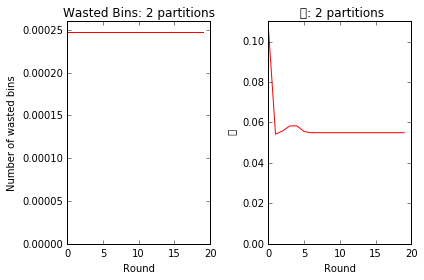

In [11]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=2, num_iterations=20)



4 PARTITIONS
ROUND	WASTE	SCORE
0	0.001	0.187
1	0.001	0.108
2	0.001	0.105
3	0.001	0.086
4	0.001	0.070
5	0.001	0.056
6	0.001	0.050
7	0.001	0.045
8	0.001	0.045
9	0.001	0.045
10	0.001	0.045
11	0.001	0.045
12	0.001	0.045
13	0.001	0.045
14	0.001	0.045
15	0.001	0.045
16	0.001	0.045
17	0.001	0.045
18	0.001	0.045
19	0.001	0.045
CPU times: user 202 ms, sys: 82 ms, total: 284 ms
Wall time: 203 ms


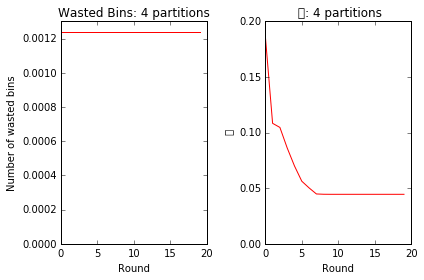

In [12]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=4, num_iterations=20)



8 PARTITIONS
ROUND	WASTE	SCORE
0	0.010	0.375
1	0.010	0.197
2	0.010	0.151
3	0.010	0.161
4	0.010	0.171
5	0.010	0.154
6	0.010	0.172
7	0.010	0.154
8	0.010	0.173
9	0.010	0.162
10	0.010	0.165
11	0.010	0.165
12	0.010	0.166
13	0.010	0.165
14	0.010	0.163
15	0.010	0.164
16	0.010	0.165
17	0.010	0.163
18	0.010	0.164
19	0.010	0.165
CPU times: user 238 ms, sys: 70 ms, total: 308 ms
Wall time: 210 ms


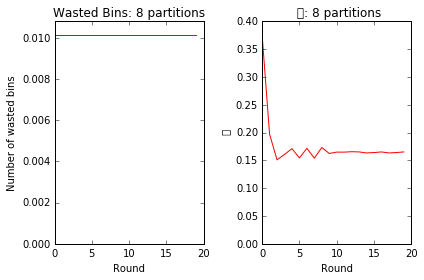

In [13]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=8, num_iterations=20)



16 PARTITIONS
ROUND	WASTE	SCORE
0	0.022	0.606
1	0.022	0.419
2	0.022	0.260
3	0.022	0.214
4	0.022	0.198
5	0.022	0.196
6	0.022	0.195
7	0.022	0.200
8	0.022	0.198
9	0.022	0.204
10	0.022	0.203
11	0.022	0.195
12	0.022	0.199
13	0.022	0.196
14	0.022	0.205
15	0.022	0.201
16	0.022	0.197
17	0.022	0.202
18	0.022	0.201
19	0.022	0.202
CPU times: user 253 ms, sys: 110 ms, total: 363 ms
Wall time: 237 ms


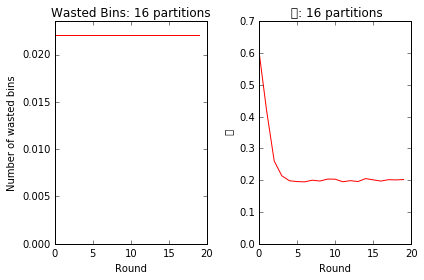

In [14]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=16, num_iterations=20)



32 PARTITIONS
ROUND	WASTE	SCORE
0	0.046	0.702
1	0.046	0.557
2	0.046	0.495
3	0.046	0.429
4	0.046	0.422
5	0.046	0.406
6	0.046	0.403
7	0.046	0.405
8	0.046	0.400
9	0.046	0.404
10	0.046	0.400
11	0.046	0.399
12	0.046	0.405
13	0.046	0.399
14	0.046	0.398
15	0.046	0.403
16	0.046	0.401
17	0.046	0.398
18	0.046	0.403
19	0.046	0.400
CPU times: user 248 ms, sys: 107 ms, total: 355 ms
Wall time: 235 ms


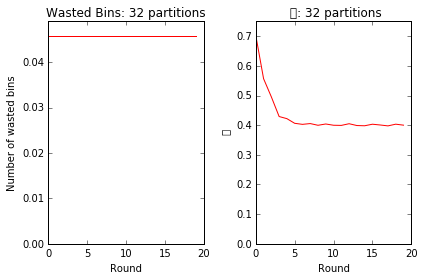

In [15]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=32, num_iterations=20)



40 PARTITIONS
ROUND	WASTE	SCORE
0	0.367	0.701
1	0.367	0.590
2	0.367	0.536
3	0.367	0.504
4	0.367	0.487
5	0.367	0.478
6	0.367	0.477
7	0.367	0.485
8	0.367	0.486
9	0.367	0.480
10	0.367	0.481
11	0.367	0.482
12	0.367	0.472
13	0.367	0.480
14	0.367	0.469
15	0.367	0.475
16	0.367	0.472
17	0.367	0.473
18	0.367	0.471
19	0.367	0.472
CPU times: user 303 ms, sys: 143 ms, total: 446 ms
Wall time: 313 ms


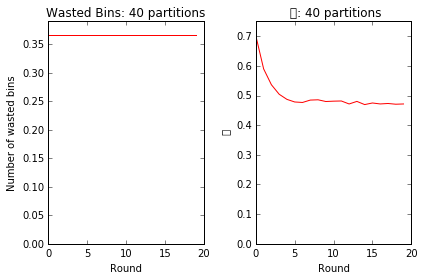

In [16]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=40, num_iterations=20)


In [17]:
%%cython
import numpy as np

cdef int UNMAPPED = -1

def fennel(int[:,::] edges,
           int num_nodes,
           int num_partitions,
           int[::] partition,
           float alpha):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    partition: A previous partition of the nodes. Set to -1's if a node has not been assigned.
    """
    
    cdef int[::] partition_sizes = None
    # The output partition
    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)
        partition_sizes = np.zeros(num_partitions, dtype=np.int32)
    else:
        partition_sizes = np.bincount(partition).astype(np.int32)
    
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    cdef float partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef float max_val = 0
    cdef float val = 0
    cdef int len_edges = len(edges)
    cdef int previous_assignment = 0

    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # New left node, so we have to assign last left

            # Remember placement of last_left in the previous assignment
            previous_assignment = partition[last_left]
            
            max_arg = 0
            max_val = partition_votes[0] - alpha * partition_sizes[0]
            if previous_assignment == 0:
                # We remove the node from its current partition before
                # deciding to re-add it, so subtract alpha to give
                # result of 1 lower partition size.
                max_val += alpha

            for arg in range(1, num_partitions):
                val = partition_votes[arg] - alpha * partition_sizes[arg]
                if previous_assignment == arg:
                    # See comment above
                    val += alpha
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_arg != previous_assignment:
                partition[last_left] = max_arg
                partition_sizes[max_arg] += 1
                if previous_assignment != UNMAPPED:
                    partition_sizes[previous_assignment] -= 1

            partition_votes[:] = 0
            last_left = left

        if partition[right] != -1:
            partition_votes[partition[right]] += 1
    
    # TODO: finish off this fencepost....
    partition[left] = 0
    
    return np.asarray(partition)

In [24]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 710 µs, sys: 376 µs, total: 1.09 ms
Wall time: 1.1 ms
wast=1.0002475860361475 edge cut = 0.11621370446766553


In [25]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,2.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 973 µs, sys: 514 µs, total: 1.49 ms
Wall time: 1.26 ms
wast=1.0002475860361475 edge cut = 0.11154430264977219


In [26]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,2.000001547)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 1.43 ms, sys: 235 µs, total: 1.66 ms
Wall time: 1.63 ms
wast=1.0002475860361475 edge cut = 0.11154430264977219


In [27]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 1.16 ms, sys: 0 ns, total: 1.16 ms
Wall time: 1.17 ms
wast=1.0012379301807377 edge cut = 0.14101140150055533


In [28]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,8,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 1.23 ms, sys: 0 ns, total: 1.23 ms
Wall time: 1.24 ms
wast=1.0160930923495914 edge cut = 0.18572205725683977


In [29]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,16,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 2.43 ms, sys: 0 ns, total: 2.43 ms
Wall time: 2.27 ms
wast=1.1250309482545184 edge cut = 0.21566516308905864


In [30]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,32,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 2.44 ms, sys: 0 ns, total: 2.44 ms
Wall time: 2.4 ms
wast=1.5370141124040604 edge cut = 0.30963120792438287


In [31]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,40,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 3.91 ms, sys: 0 ns, total: 3.91 ms
Wall time: 3.84 ms
wast=1.822233226046051 edge cut = 0.3587052610104948


In [46]:
def run_fennel_restreaming(edges, num_nodes, num_partitions, num_iterations):
    print('{} PARTITIONS'.format(num_partitions))
    assignments = None
    # We will explore this parameter in a future post. This is sub-optimal
    alphas = np.linspace(1.251608191745264e-07, 7.588951557309824e-05, num_iterations)
    waste_scores, edge_score_values = [], []
    print('ROUND\tALPHA\tWASTE\tSCORE')
    for i in range(num_iterations):
        alpha = alphas[i]
        assignments = fennel(edges, NUM_NODES, num_partitions, assignments, alpha)
        (waste, edge_score) = score(assignments, edges)
        print('{}\t{:.1e}\t{:0.3f}\t{:0.3f}'.format(i, alpha, waste, edge_score))
        waste_scores.append(waste)
        edge_score_values.append(edge_score)
    draw_figures(waste_scores, edge_score_values, num_partitions)

# K = 2

2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.116
1	4.1e-06	0.000	0.063
2	8.1e-06	0.000	0.058
3	1.2e-05	0.000	0.057
4	1.6e-05	0.000	0.056
5	2.0e-05	0.000	0.056
6	2.4e-05	0.000	0.056
7	2.8e-05	0.000	0.056
8	3.2e-05	0.000	0.056
9	3.6e-05	0.000	0.055
10	4.0e-05	0.000	0.055
11	4.4e-05	0.000	0.055
12	4.8e-05	0.000	0.055
13	5.2e-05	0.000	0.055
14	5.6e-05	0.000	0.055
15	6.0e-05	0.000	0.055
16	6.4e-05	0.000	0.055
17	6.8e-05	0.000	0.055
18	7.2e-05	0.000	0.055
19	7.6e-05	0.000	0.055
CPU times: user 224 ms, sys: 81.4 ms, total: 305 ms
Wall time: 216 ms


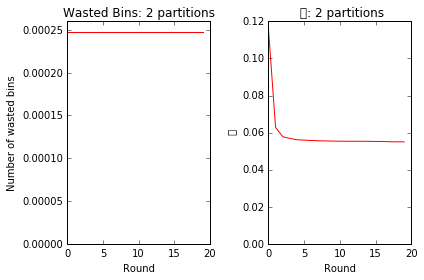

In [22]:
#alpha = 1.
%time run_fennel_restreaming(edges, NUM_NODES, 2, 20)


2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.015	0.070
1	4.1e-06	0.048	0.037
2	8.1e-06	0.053	0.034
3	1.2e-05	0.054	0.034
4	1.6e-05	0.055	0.034
5	2.0e-05	0.056	0.034
6	2.4e-05	0.056	0.034
7	2.8e-05	0.056	0.034
8	3.2e-05	0.056	0.034
9	3.6e-05	0.056	0.034
10	4.0e-05	0.056	0.034
11	4.4e-05	0.056	0.034
12	4.8e-05	0.056	0.034
13	5.2e-05	0.056	0.034
14	5.6e-05	0.056	0.034
15	6.0e-05	0.056	0.034
16	6.4e-05	0.056	0.034
17	6.8e-05	0.056	0.034
18	7.2e-05	0.056	0.034
19	7.6e-05	0.056	0.034
CPU times: user 289 ms, sys: 108 ms, total: 397 ms
Wall time: 268 ms


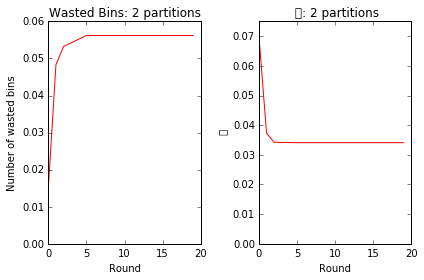

In [26]:
#utilisation de alpha
%time run_fennel_restreaming(edges, NUM_NODES, 2, 20)


# k = 4

4 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.001	0.141
1	4.1e-06	0.001	0.076
2	8.1e-06	0.003	0.068
3	1.2e-05	0.003	0.062
4	1.6e-05	0.002	0.057
5	2.0e-05	0.003	0.053
6	2.4e-05	0.001	0.052
7	2.8e-05	0.001	0.051
8	3.2e-05	0.001	0.051
9	3.6e-05	0.001	0.051
10	4.0e-05	0.002	0.051
11	4.4e-05	0.001	0.051
12	4.8e-05	0.001	0.051
13	5.2e-05	0.001	0.051
14	5.6e-05	0.001	0.051
15	6.0e-05	0.001	0.051
16	6.4e-05	0.001	0.051
17	6.8e-05	0.001	0.051
18	7.2e-05	0.001	0.051
19	7.6e-05	0.001	0.051
CPU times: user 318 ms, sys: 72.2 ms, total: 390 ms
Wall time: 297 ms


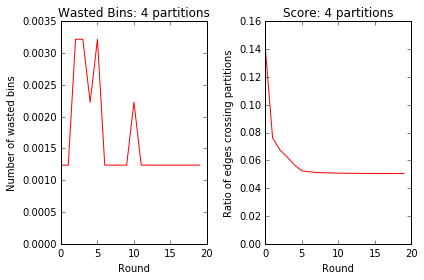

In [34]:
#sans alpha
%time run_fennel_restreaming(edges, NUM_NODES, 4, 20)


4 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.031	0.107
1	4.1e-06	0.014	0.066
2	8.1e-06	0.005	0.059
3	1.2e-05	0.011	0.053
4	1.6e-05	0.013	0.050
5	2.0e-05	0.013	0.050
6	2.4e-05	0.012	0.050
7	2.8e-05	0.011	0.050
8	3.2e-05	0.011	0.050
9	3.6e-05	0.011	0.050
10	4.0e-05	0.011	0.050
11	4.4e-05	0.011	0.050
12	4.8e-05	0.011	0.050
13	5.2e-05	0.011	0.050
14	5.6e-05	0.011	0.050
15	6.0e-05	0.011	0.050
16	6.4e-05	0.011	0.050
17	6.8e-05	0.011	0.050
18	7.2e-05	0.011	0.050
19	7.6e-05	0.011	0.050
CPU times: user 294 ms, sys: 126 ms, total: 419 ms
Wall time: 292 ms


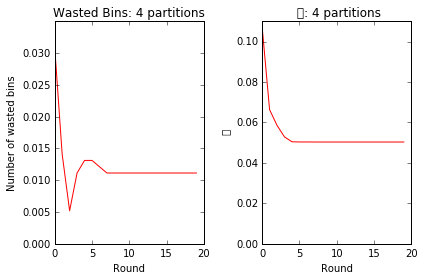

In [27]:
%time run_fennel_restreaming(edges, NUM_NODES, 4, 20)


# K=8

8 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.016	0.186
1	4.1e-06	0.018	0.115
2	8.1e-06	0.016	0.107
3	1.2e-05	0.014	0.103
4	1.6e-05	0.014	0.098
5	2.0e-05	0.014	0.096
6	2.4e-05	0.012	0.096
7	2.8e-05	0.012	0.095
8	3.2e-05	0.012	0.095
9	3.6e-05	0.012	0.094
10	4.0e-05	0.012	0.093
11	4.4e-05	0.012	0.093
12	4.8e-05	0.012	0.092
13	5.2e-05	0.012	0.090
14	5.6e-05	0.010	0.090
15	6.0e-05	0.012	0.090
16	6.4e-05	0.012	0.090
17	6.8e-05	0.012	0.090
18	7.2e-05	0.012	0.090
19	7.6e-05	0.012	0.090
CPU times: user 223 ms, sys: 43.2 ms, total: 267 ms
Wall time: 200 ms


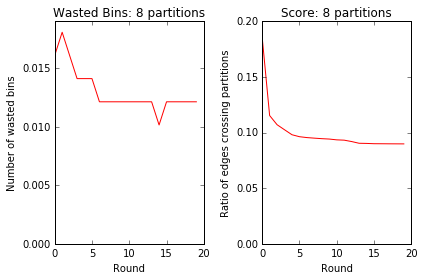

In [35]:
%time run_fennel_restreaming(edges, NUM_NODES, 8, 20)


8 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.424	0.135
1	4.1e-06	0.832	0.084
2	8.1e-06	1.012	0.075
3	1.2e-05	1.094	0.069
4	1.6e-05	1.107	0.068
5	2.0e-05	1.107	0.068
6	2.4e-05	1.107	0.068
7	2.8e-05	1.107	0.068
8	3.2e-05	1.107	0.068
9	3.6e-05	1.107	0.068
10	4.0e-05	1.107	0.068
11	4.4e-05	1.107	0.068
12	4.8e-05	1.107	0.068
13	5.2e-05	1.107	0.068
14	5.6e-05	1.107	0.068
15	6.0e-05	1.107	0.068
16	6.4e-05	1.107	0.068
17	6.8e-05	1.107	0.068
18	7.2e-05	1.107	0.068
19	7.6e-05	1.107	0.068
CPU times: user 278 ms, sys: 133 ms, total: 411 ms
Wall time: 277 ms


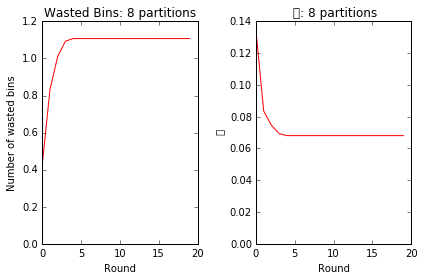

In [28]:
#avec alphas
%time run_fennel_restreaming(edges, NUM_NODES, 8, 20)


# k = 16

16 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.125	0.216
1	4.1e-06	0.117	0.130
2	8.1e-06	0.121	0.120
3	1.2e-05	0.117	0.112
4	1.6e-05	0.117	0.110
5	2.0e-05	0.117	0.108
6	2.4e-05	0.117	0.107
7	2.8e-05	0.117	0.107
8	3.2e-05	0.117	0.107
9	3.6e-05	0.117	0.107
10	4.0e-05	0.117	0.107
11	4.4e-05	0.117	0.107
12	4.8e-05	0.117	0.107
13	5.2e-05	0.117	0.107
14	5.6e-05	0.117	0.107
15	6.0e-05	0.117	0.107
16	6.4e-05	0.117	0.107
17	6.8e-05	0.117	0.107
18	7.2e-05	0.117	0.107
19	7.6e-05	0.117	0.107
CPU times: user 266 ms, sys: 64.6 ms, total: 331 ms
Wall time: 223 ms


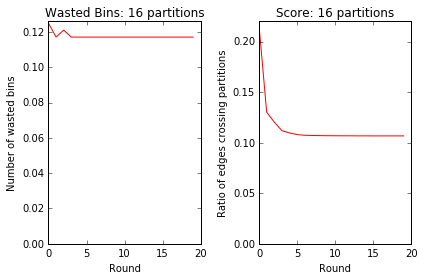

In [36]:
%time run_fennel_restreaming(edges, NUM_NODES, 16, 20)


16 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.692	0.141
1	4.1e-06	0.957	0.088
2	8.1e-06	1.040	0.078
3	1.2e-05	1.076	0.073
4	1.6e-05	1.084	0.071
5	2.0e-05	1.111	0.071
6	2.4e-05	1.135	0.070
7	2.8e-05	1.139	0.070
8	3.2e-05	1.139	0.070
9	3.6e-05	1.139	0.070
10	4.0e-05	1.139	0.070
11	4.4e-05	1.139	0.070
12	4.8e-05	1.139	0.070
13	5.2e-05	1.139	0.070
14	5.6e-05	1.139	0.070
15	6.0e-05	1.139	0.070
16	6.4e-05	1.139	0.070
17	6.8e-05	1.139	0.070
18	7.2e-05	1.139	0.070
19	7.6e-05	1.139	0.070
CPU times: user 316 ms, sys: 90.8 ms, total: 407 ms
Wall time: 316 ms


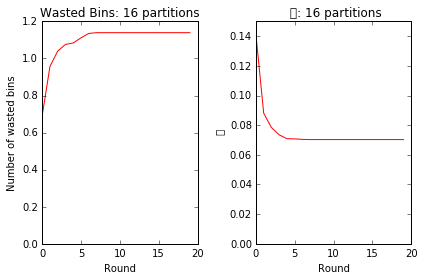

In [30]:
%time run_fennel_restreaming(edges, NUM_NODES, 16, 20)


16 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	2.5e-08	0.695	0.141
1	3.3e-07	0.957	0.091
2	6.4e-07	1.064	0.083
3	9.5e-07	1.080	0.080
4	1.3e-06	1.088	0.078
5	1.6e-06	1.092	0.073
6	1.9e-06	1.115	0.069
7	2.2e-06	1.139	0.069
8	2.5e-06	1.143	0.069
9	2.8e-06	1.143	0.069
10	3.1e-06	1.143	0.069
11	3.4e-06	1.143	0.069
12	3.7e-06	1.143	0.069
13	4.0e-06	1.143	0.069
14	4.3e-06	1.143	0.069
15	4.7e-06	1.143	0.069
16	5.0e-06	1.143	0.069
17	5.3e-06	1.143	0.069
18	5.6e-06	1.143	0.069
19	5.9e-06	1.143	0.069
CPU times: user 333 ms, sys: 121 ms, total: 454 ms
Wall time: 320 ms


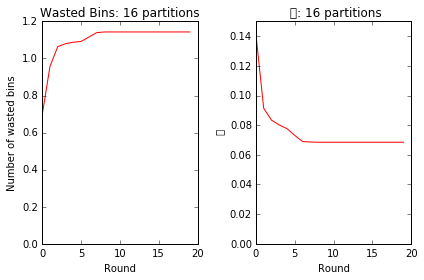

In [39]:
%time run_fennel_restreaming(edges, NUM_NODES, 16, 20)


# K = 32

32 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.537	0.310
1	4.1e-06	0.561	0.253
2	8.1e-06	0.561	0.248
3	1.2e-05	0.561	0.244
4	1.6e-05	0.561	0.245
5	2.0e-05	0.561	0.244
6	2.4e-05	0.561	0.244
7	2.8e-05	0.561	0.243
8	3.2e-05	0.561	0.243
9	3.6e-05	0.561	0.243
10	4.0e-05	0.561	0.243
11	4.4e-05	0.561	0.243
12	4.8e-05	0.561	0.243
13	5.2e-05	0.561	0.243
14	5.6e-05	0.561	0.243
15	6.0e-05	0.561	0.243
16	6.4e-05	0.561	0.243
17	6.8e-05	0.561	0.243
18	7.2e-05	0.561	0.243
19	7.6e-05	0.561	0.243
CPU times: user 269 ms, sys: 86.6 ms, total: 356 ms
Wall time: 237 ms


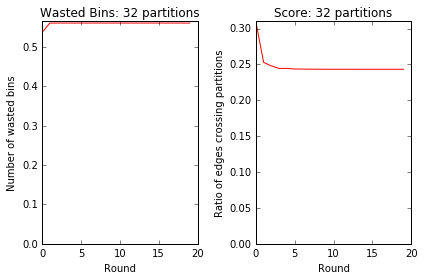

In [37]:
%time run_fennel_restreaming(edges, NUM_NODES, 32, 20)


32 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	1.622	0.144
1	4.1e-06	2.169	0.088
2	8.1e-06	2.438	0.081
3	1.2e-05	2.486	0.077
4	1.6e-05	2.510	0.074
5	2.0e-05	2.740	0.070
6	2.4e-05	2.890	0.067
7	2.8e-05	2.890	0.067
8	3.2e-05	2.890	0.067
9	3.6e-05	2.890	0.067
10	4.0e-05	2.890	0.067
11	4.4e-05	2.890	0.067
12	4.8e-05	2.890	0.067
13	5.2e-05	2.890	0.067
14	5.6e-05	2.890	0.067
15	6.0e-05	2.890	0.067
16	6.4e-05	2.890	0.067
17	6.8e-05	2.890	0.067
18	7.2e-05	2.890	0.067
19	7.6e-05	2.890	0.067
CPU times: user 276 ms, sys: 101 ms, total: 377 ms
Wall time: 244 ms


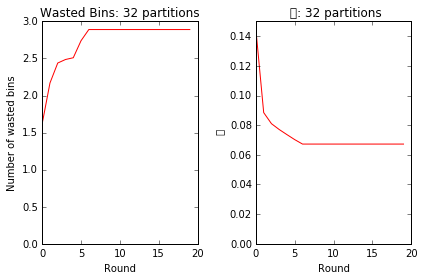

In [31]:
%time run_fennel_restreaming(edges, NUM_NODES, 32, 20)


32 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	5.3e-07	1.622	0.144
1	4.5e-06	2.169	0.088
2	8.5e-06	2.438	0.081
3	1.2e-05	2.486	0.077
4	1.6e-05	2.510	0.074
5	2.0e-05	2.740	0.070
6	2.4e-05	2.890	0.067
7	2.8e-05	2.890	0.067
8	3.2e-05	2.890	0.067
9	3.6e-05	2.890	0.067
10	4.0e-05	2.890	0.067
11	4.4e-05	2.890	0.067
12	4.8e-05	2.890	0.067
13	5.2e-05	2.890	0.067
14	5.6e-05	2.890	0.067
15	6.0e-05	2.890	0.067
16	6.4e-05	2.890	0.067
17	6.8e-05	2.890	0.067
18	7.2e-05	2.890	0.067
19	7.6e-05	2.890	0.067
CPU times: user 307 ms, sys: 78.8 ms, total: 386 ms
Wall time: 259 ms


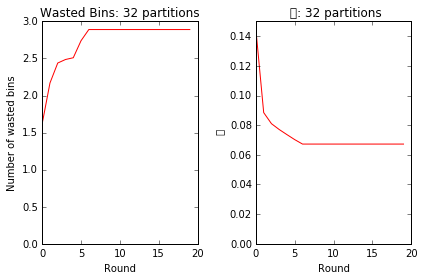

In [44]:
%time run_fennel_restreaming(edges, NUM_NODES, 32, 20)
